# A look at music charts: The effect on artist exposure/performance

## Notebook by [Jeff Sontag](https://github.com/jmoso13)


# Introduction

Musicians rely heavily on online music charts for exposure and validation. Fans rely on these same charts to make finding good music easy and reliable. But how does performance on a popular music chart translate into exposure for an artist and can fans really rely on an algorithm to find the most compelling new music? As both a musician and lover of new music I set out to look at one of the most dominant music charts, [Hype Machine](https://hypem.com), and see what performance on this chart means for listeners and artists. 

Data was collected multiple times every day starting Jan 1, 2017. The Hype Machine Top 50 chart was scraped for artist[s], track title, rank, and links to Spotify, SoundCloud, and Apple Music. After organizing and cleaning all unique tracks into a single dataset, I was able to calculate a track's peak rank on the chart, the number of days it charted, and whether or not a track dropped off the chart to then re-emerge later.

After calculating these basic statistics the tracks' SoundCloud links were used to collect information on their current SoundCloud plays, reposts, likes, and number of followers an artist had. Tracks that were not available on SoundCloud were excluded from this dataset, leaving 1205 tracks that had charted between January and March 2017.


# Step 1: Defining the goal

For this analysis, much of what I hope to accomplish will be exploratory. What sorts of associations can we find among tracks that perform well on SoundCloud vs. those that perform well on Hype Machine? Are these the same tracks? These sorts of questions are important to listeners who likely hope that tracks performing well on Hype Machine really are the best of the best.

To accomplish this goal, I will hope to define in some sense what a "successful" track looks like on SoundCloud. Is this a track that receives a lot of plays? A track that receives a lot of likes/reposts? Or a combination of these statistics?

Once SoundCloud "success" is more or less defined, relationships between a track's peak rank on Hype Machine and SoundCloud success will be explored. Finally I'll turn to modelling techniques to see if it is possile to predict SoundCloud success based on a track's peak position on the Hype Machine chart.

As a bonus, I also hope to see if we can segment the data using unsupervised learning techniques. These techniques allow the computer to look at data and cluster it into interpretable groups. This may give us a sense of the type of artists that are showing up on Hype Machine and how they are performing.


# Step 2: Probing the Data

I'll be using Python 3.4 and the following libraries to explore the data (descriptions taken from [RHiever](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) along with inspiration for proper analysis process):

1. **NumPy**: Provides a fast numerical array structure and helper functions.
2. **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
3. **scikit-learn**: The essential Machine Learning package in Python.
4. **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
5. **Seaborn**: Advanced statistical plotting library.

Let's start by importing the libraries we'll be using.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from datetime import datetime

%matplotlib inline

Now let's import the dataset. NA values were represented as -1's and empty cells.

.head() allows us to see the first 5 observations, checking that everything looks good.

In [2]:
hype_m = pd.read_csv("april_sc_join_init.csv", na_values = ['', '-1'])
hype_m.head()

,Unnamed: 0,Artist,Bandcamp Link,DateTime,Other Links,Rank,Remix Artist,Soundcloud Link,Spotify Link,Track ID,...,First Date Seen,Days On Chart,Number of Re-Emergences,SC Like to Play Ratio,SC Repost to Play Ratio,sc_acct_followers,sc_likes,sc_plays,sc_pull_time,sc_reposts
0,0,Hey Violet,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,1.0,Prince Fox Remix,https://soundcloud.com/princefoxmusic/gmapfremix,https://open.spotify.com/track/4lgpXc2IafbNTUD...,2kpqe,...,2017-02-01 05:02:09,0 days 03:53:44.000000000,NaN,0.020575,0.004687,66615.0,3982.0,193533.0,04-04-2017 07:14:09,907.0
1,1,Marbert Rocel,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,2.0,Nico Pusch Bootleg Remix,https://soundcloud.com/sunset-boulevard/marber...,NaN,1m6re,...,2017-02-01 05:02:09,0 days 00:00:00.000000000,NaN,0.011976,0.002585,285.0,366.0,30560.0,04-04-2017 07:14:09,79.0
2,2,Kiiara,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,3.0,HERO VHS Pop Remix,https://soundcloud.com/yourfriendhero/kiiara-h...,NaN,2kn95,...,2017-02-01 05:02:09,0 days 00:00:00.000000000,NaN,NaN,NaN,NaN,NaN,NaN,04-04-2017 07:14:09,NaN
3,3,Vincent,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,4.0,NaN,https://soundcloud.com/vincent_official/her,https://open.spotify.com/track/0ePeGyJeURzbmXv...,2fcaq,...,2017-02-01 05:02:09,0 days 14:05:52.000000000,NaN,0.027213,0.005011,101212.0,63404.0,2329928.0,04-04-2017 07:14:09,11676.0
4,4,Aaron Taos,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,5.0,NaN,https://soundcloud.com/aarontaos/off-my-mind,https://open.spotify.com/track/3MFaRVxcPCa9mbX...,2kn8d,...,2017-02-01 05:02:09,2 days 13:45:26.000000000,1.0,0.004583,0.001052,1849.0,924.0,201602.0,04-04-2017 07:14:09,212.0


So the data appears to be in decent format, there are a lot of columns we don't necessarily need to keep track of so let's subset the data into SoundCloud-specific stats and work with that. 

There's also a bit of tidying that needs to be done with some of the datetime variables. Let's take care of that now.

In [3]:
### Tidying

# Converts to decimal days
hype_m["Days On Chart"] = pd.to_timedelta(hype_m["Days On Chart"])/np.timedelta64(1,'D')

# Change re-emergence NAs to 0
hype_m["Number of Re-Emergences"] = hype_m["Number of Re-Emergences"].fillna(0)

# Change date first seen to datetime
hype_m["First Date Seen"] = pd.to_datetime(hype_m["First Date Seen"]).astype(np.int64)


### Creating New Dataset

# Creating SoundCloud-Specific Dataset
h_sc = hype_m[["SC Like to Play Ratio", "SC Repost to Play Ratio", "sc_acct_followers", 
               "sc_likes", "sc_plays", "sc_reposts", "Peak Rank", "Days On Chart", 
               "Number of Re-Emergences", "First Date Seen", "Track ID"]]

# Dropping NA values
h_sc = h_sc.dropna()

An anticipated worry is that tracks that have been up a less amount of time will naturally skew to less plays and less likes/reposts. In order to keep a mostly homogenous set we'll drop all observations that were recorded after March 20, 2017. This should give tracks included in the dataset a fairly good amount of time to accumulate a good representation of plays etc.

In [4]:
# Getting an epoch time to compare w/
date = [datetime(2017, 3, 20)]
index = pd.DatetimeIndex(date)
epoch_cutoff = pd.to_datetime(index).astype(np.int64)

# Reducing sc data to those observations seen before 2 weeks ago
h_sc = h_sc.loc[h_sc["First Date Seen"] < epoch_cutoff[0]]

Now that the data is sufficiently "tidied" let's get a first look at some of our basic stats.

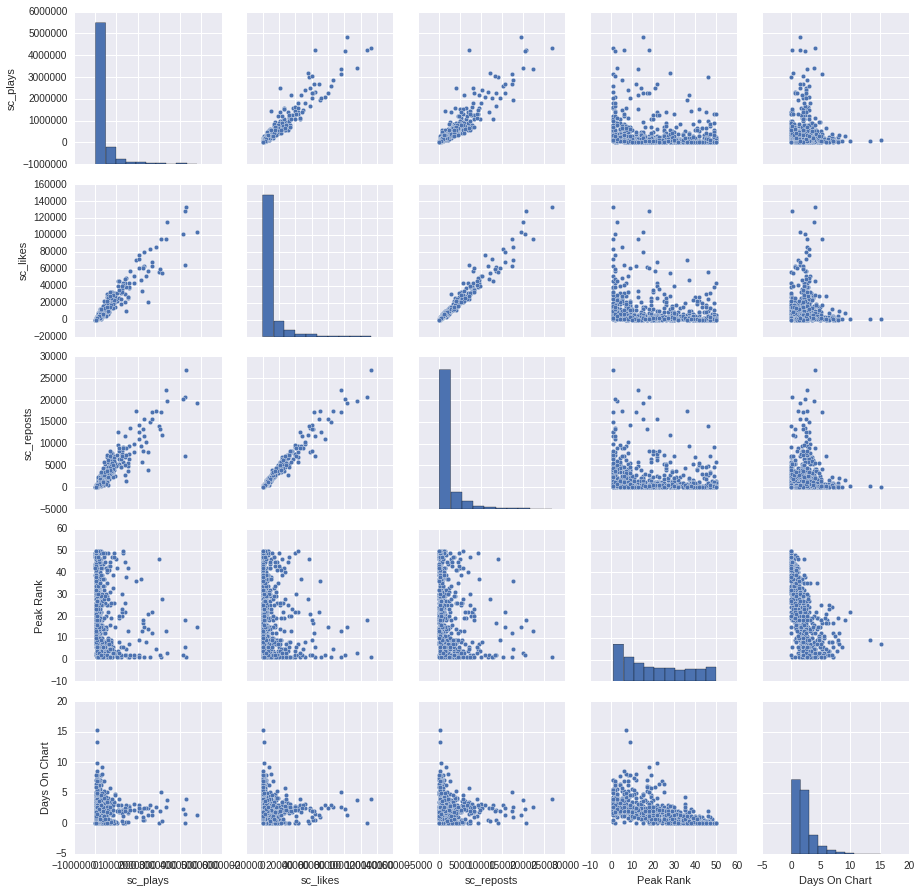

In [16]:
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]])

There appear to be a few observations that could be considered outliers. These datapoints have high plays on soundcloud and thus are dwarfing the other observations to the point where we cannot observe relationships very well. I will label them as "viral" and separate them out.

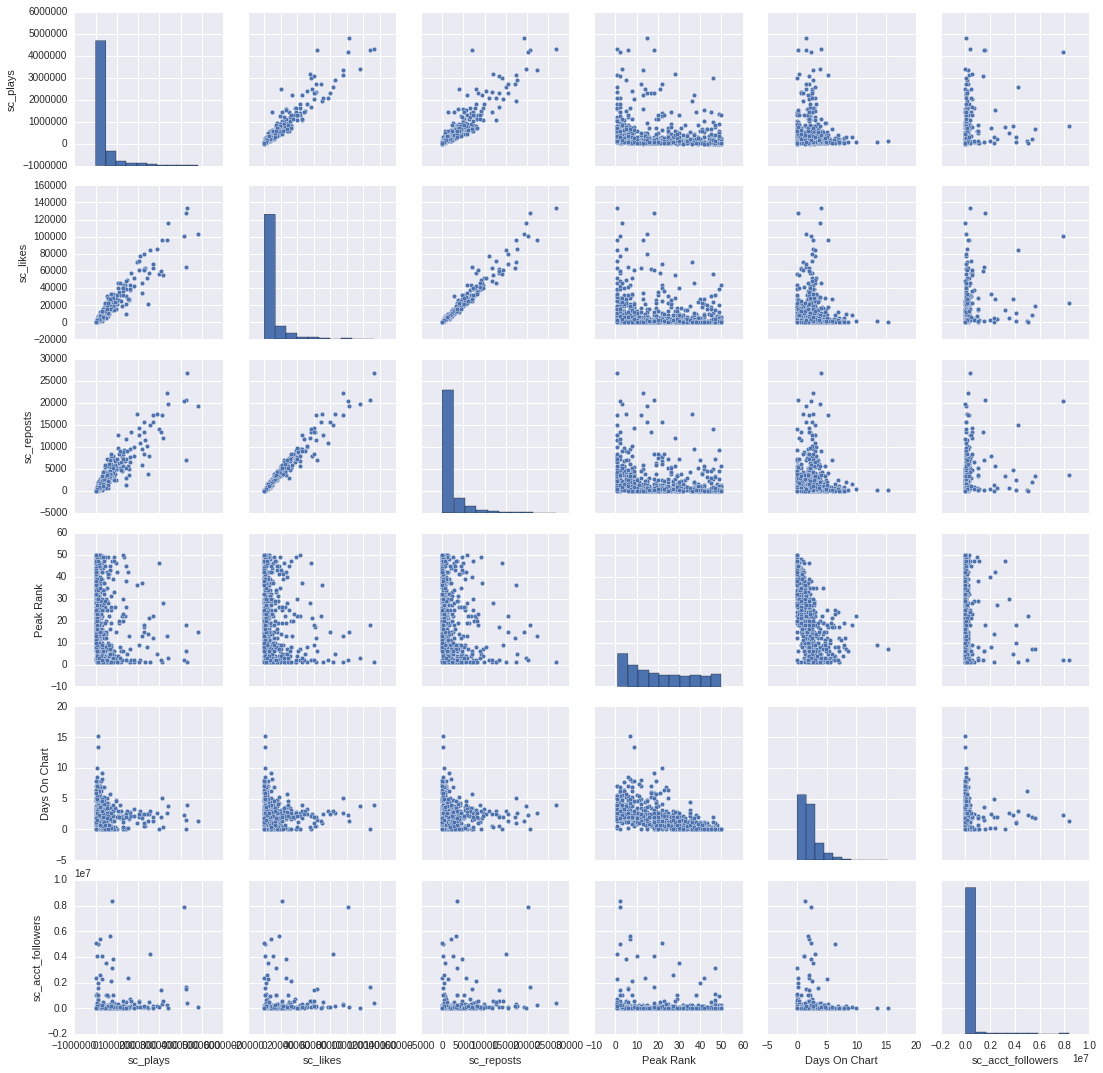

In [6]:
# Separating out the large outliers "viral"
large_examples = h_sc.loc[(h_sc["sc_likes"] > 500000) | (h_sc["sc_plays"] > 5e6)]

# Get rid of these examples from pairplot
h_sc = h_sc.loc[(h_sc["sc_likes"] < 500000) & (h_sc["sc_plays"] < 5e6)]

# Plot again
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]])

Much better!

Now we can observe some definite relationships between some of our variables.

1. Unsurprisingly, tracks with more plays tend to boast more likes and reposts as well, these all look correlated
2. Tracks with a lower Peak Rank (a bit backwards, 1 being the lowest but also best spot) appear to spend more days on the chart
3. It's hard to observe a definite trend between Peak Rank and SC Plays, but there do appear to be a cluster of tracks that reached more plays and peaked at lower number ranks

But what about our viral tracks? Let's check those out before we go too deep into our new dataset.

In [7]:
large_examples[["sc_plays", "sc_likes", "sc_reposts"]].describe()

,sc_plays,sc_likes,sc_reposts
count,8.000000e+00,8.000000e+00,8.000000
mean,4.593777e+07,7.258160e+05,73060.750000
std,3.773934e+07,5.364379e+05,34995.296144
min,7.746107e+06,1.674800e+05,24771.000000
25%,1.975981e+07,3.590425e+05,57230.000000
50%,3.058577e+07,5.672990e+05,67773.500000
75%,7.100461e+07,9.477828e+05,87927.250000
max,1.183312e+08,1.836411e+06,140933.000000


Our top track has 118 million plays! Let's check out what track that is

In [8]:
max_id = large_examples["sc_plays"].argmax()

print("Top Track:\n" + hype_m.loc[max_id,"Artist"] + " - " + hype_m.loc[max_id,"Track Title"])

Top Track:
Migos - Bad and Boujee (Feat. Lil Uzi Vert) (Prod. By Metro Boomin)


Lol. Of course it's [Migos](https://soundcloud.com/migosatl/bad-and-boujee-feat-lil-uzi-vert-prod-by-metro-boomin).

Well let's see how Bad and Boujee did on Hype Machine.

In [9]:
print("Bad and Boujee reached a top rank of: " + str(large_examples.loc[max_id, "Peak Rank"]))

Bad and Boujee reached a top rank of: 27


Hmm. Interesting, so Bad and Boujee only reached 27 on Hype Machine, probably one of the most dominant (yet annoying) songs of the year. I'm not sure if I respect their algorithm more or less for that.

One thing that is an issue here is that Bad and Boujee came out 8 months ago. Meaning it may have peaked higher on Hype Machine before we actually started recording data on Jan 1 of this year. Then, for some reason, in the past three months (*cough coachella*) the track resurged in popularity on the chart. This would indicate that we may need more data to draw any conclusions about this track. 

Still, let's take a look at the rest of our "viral" tracks and see how they performed on the charts.

In [13]:
viral_id = large_examples.index

viral_artists = hype_m.loc[viral_id, "Artist"]
viral_tracks = hype_m.loc[viral_id, "Track Title"]
viral_ranks = hype_m.loc[viral_id, "Peak Rank"]

print("Artist - Title:\nPeak Rank\n")

for i in viral_id:
    print(viral_artists[i] + " - " + viral_tracks[i] + ": \n" + str(viral_ranks[i])+ "\n")

Artist - Title:
Peak Rank

Migos - Bad and Boujee (Feat. Lil Uzi Vert) (Prod. By Metro Boomin): 
27

PETIT BISCUIT - Sunset Lover: 
6

Towkio - Heaven Only Knows (feat. Chance The Rapper, Lido & Eryn Allen Kane): 
26

Rob $TONE - Chill Bill: 
47

YOUNG MA - OOOUUU (intro): 
23

6LACK - PRBLMS: 
7

Kungs Vs. Cookin' On 3 Burners - This Girl: 
11

Khalid - Location: 
17



Interesting that not one of our "viral" tracks reached the top spot on Hype Machine. Nothing definitive here yet but it is giving shape to the idea that Hype Machine may not be the best predictor of "viral" tracks.

Let's return to our bigger dataset...

The next thing that may be helpful to see is a category that splits "Peak Rank" into three categories:
1. "Top 10" Tracks
2. Tracks that peaked 11-25 - "Mid-Tier"
3. Bottom Half Tracks - "Low-Tier"

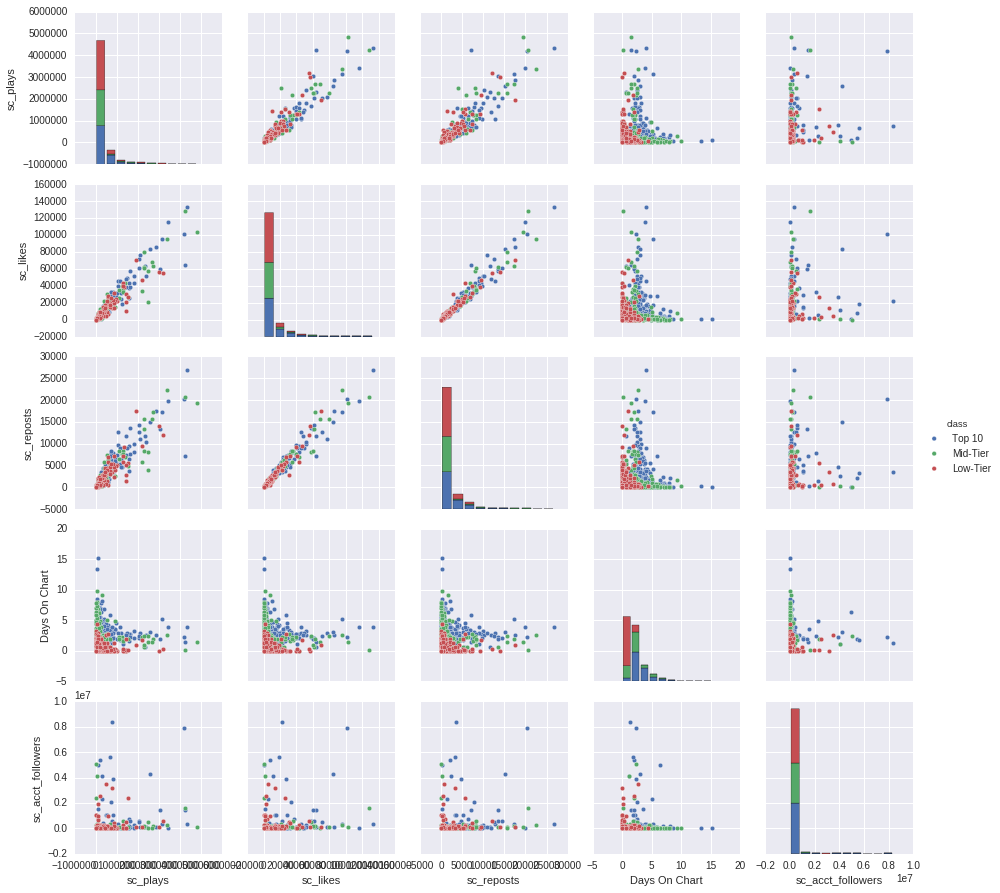

In [15]:
# Classify in an easier way
h_sc.loc[h_sc["Peak Rank"] <= 10, "class"] = "Top 10"
h_sc.loc[(h_sc["Peak Rank"] > 10) & (h_sc["Peak Rank"] < 26), "class"] = "Mid-Tier"
h_sc.loc[h_sc["Peak Rank"] > 25, "class"] = "Low-Tier"

# Plot with colors to see any grouping info
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Days On Chart", 
                  "sc_acct_followers", "class"]], hue="class")

So this is cool. Definitely appears that there are some clusters. In general, low-tier tracks look to get less plays, likes, and reposts on average than mid-tier and top 10 tracks.

Violin plots are cool to use to see this a bit more clearly.

(-500000, 1250000)

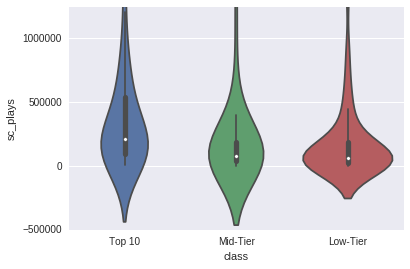

In [28]:
sb.violinplot(x="class", y = "sc_plays", data = h_sc)
plt.ylim(-500000,1250000)

The distributions show that there could be some correlation between soundcloud plays and where a track peaks on Hype Machine. Let's get some real numbers behind that hypothesis.

In [41]:
h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]].corr()

,sc_plays,sc_likes,sc_reposts,Peak Rank,Days On Chart
sc_plays,1.000000,0.952688,0.923642,-0.188496,0.021290
sc_likes,0.952688,1.000000,0.980607,-0.202870,0.029543
sc_reposts,0.923642,0.980607,1.000000,-0.214232,0.036271
Peak Rank,-0.188496,-0.202870,-0.214232,1.000000,-0.628771
Days On Chart,0.021290,0.029543,0.036271,-0.628771,1.000000


So a correlation of -0.188 between Peak Rank and sc_plays is pretty surprising to me. Feeling a bit low, it flies a bit against conventional wisdom that reaching the top of Hype Machine results in pretty strong exposure. 

However, there could be explanations for such a discrepancy, there still seem to be a pretty good amount of potential outliers that could be skewing the data. Also, number of soundcloud followers could play a role in soundcloud plays.

Another potentiality is that showing up at any rank on Hype Machine is equally boosting for SC plays unless you reach the top spots. Let's see if we segment the dataset to only include data from the top 10 if that correlation improves.

In [42]:
h_sc.loc[h_sc["class"]=="Top 10", ["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]].corr()

,sc_plays,sc_likes,sc_reposts,Peak Rank,Days On Chart
sc_plays,1.000000,0.956239,0.919068,-0.237404,-0.122183
sc_likes,0.956239,1.000000,0.981448,-0.245777,-0.106256
sc_reposts,0.919068,0.981448,1.000000,-0.262003,-0.109348
Peak Rank,-0.237404,-0.245777,-0.262003,1.000000,-0.050997
Days On Chart,-0.122183,-0.106256,-0.109348,-0.050997,1.000000


So segmenting the data jumped our correlation between peak rank and plays by 5%. Not bad! Gives a little credence to our hypothesis that reaching the top spots is a bit more beneficial for exposure than the middle spots.

Just for fun let's check those as well.

In [43]:
h_sc.loc[h_sc["class"]=="Mid-Tier", ["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]].corr()

,sc_plays,sc_likes,sc_reposts,Peak Rank,Days On Chart
sc_plays,1.000000,0.960862,0.936377,-0.015675,-0.134743
sc_likes,0.960862,1.000000,0.979303,0.021974,-0.155274
sc_reposts,0.936377,0.979303,1.000000,0.014451,-0.150852
Peak Rank,-0.015675,0.021974,0.014451,1.000000,-0.121808
Days On Chart,-0.134743,-0.155274,-0.150852,-0.121808,1.000000


WOW.

The correlation between plays and peak rank for mid-tier tracks is a near non-existent 1.5%. Definitely giving us some idea that reaching any spot between 11 and 25 is equally beneficial for plays. Artists should therefore plan on reaching spots above 10 if they want to see any incremental increase in plays for reaching a higher rank.